In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, mean, max as spark_max, lit
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

In [0]:
spark = SparkSession.builder.appName("EarthquakeClustering").getOrCreate()

In [0]:
df = spark.read.parquet("abfss://gold@bigdatacuoiky.dfs.core.windows.net/earthquake_events_gold/")
df.show(5)
df.printSchema()
df.describe().show()
df.columns

+------------+------------+-----------+-----------+--------------------+--------------------+---+----+-------+--------------------+--------------------+---------+
|          id|   longitude|   latitude|  elevation|               title|   place_description|sig| mag|magType|                time|             updated|sig_class|
+------------+------------+-----------+-----------+--------------------+--------------------+---+----+-------+--------------------+--------------------+---------+
|ak0219pcfvx9|   -155.2341|     65.771|        4.0|M 0.9 - 54 km E o...|54 km E of Huslia...| 12| 0.9|     ml|2021-07-30 23:59:...|2021-08-13 03:19:...|      Low|
|  ok2021ovmz|-97.50583333|36.97083333|       3.28|M 1.9 - 9 km WSW ...|9 km WSW of Hunne...| 53|1.85|     ml|2021-07-30 23:54:...|2021-08-02 14:25:...|      Low|
|  nc73602856|-119.5573333|    38.4215|       5.14|M 1.6 - 26km ENE ...|26km ENE of Darda...| 39|1.59|     md|2021-07-30 23:54:...|2021-08-07 06:38:...|      Low|
|  tx2021ovmy|-98.6308

['id',
 'longitude',
 'latitude',
 'elevation',
 'title',
 'place_description',
 'sig',
 'mag',
 'magType',
 'time',
 'updated',
 'sig_class']

In [0]:
# Loại bỏ dòng thiếu dữ liệu
df = df.dropna(subset=['longitude', 'latitude', 'mag', 'elevation'])

# Chuyển kiểu dữ liệu về float (nếu cần)
for c in ['longitude', 'latitude', 'mag', 'elevation']:
    df = df.withColumn(c, col(c).cast("double"))

In [0]:
features = ['longitude', 'latitude', 'mag', 'elevation']
assembler = VectorAssembler(inputCols=features, outputCol="features_vec")
df_vec = assembler.transform(df)

scaler = StandardScaler(inputCol="features_vec", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_vec)
df_scaled = scaler_model.transform(df_vec)

In [0]:
inertias = []
silhouette_scores = []
K_range = list(range(2, 11))

for k in K_range:
    kmeans = KMeans(featuresCol="features", k=k, seed=42)
    model = kmeans.fit(df_scaled)
    predictions = model.transform(df_scaled)
    inertia = model.summary.trainingCost
    evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
    silhouette = evaluator.evaluate(predictions)
    inertias.append(inertia)
    silhouette_scores.append(silhouette)

In [0]:
import numpy as np
optimal_k = K_range[int(np.argmax(silhouette_scores))]
print(f"Số cụm tối ưu: {optimal_k}")

kmeans = KMeans(featuresCol="features", k=optimal_k, seed=42)
model = kmeans.fit(df_scaled)
df_clustered = model.transform(df_scaled)

Số cụm tối ưu: 2


In [0]:
from pyspark.sql.functions import mean, max as spark_max, count, when, lit

cluster_stats = df_clustered.groupBy("prediction").agg(
    count("*").alias("count"),
    mean("mag").alias("mag_mean"),
    spark_max("mag").alias("mag_max")
).orderBy(col("mag_mean").desc())

# Lấy ngưỡng phân loại
mag_thresholds = cluster_stats.select("mag_mean").toPandas()
mag_high = mag_thresholds["mag_mean"].quantile(0.75)
mag_medium = mag_thresholds["mag_mean"].quantile(0.5)

def risk_level(mag):
    if mag >= mag_high:
        return "RỦI RO CAO"
    elif mag >= mag_medium:
        return "RỦI RO TRUNG BÌNH"
    else:
        return "RỦI RO THẤP"

import pandas as pd
cluster_stats_pd = cluster_stats.toPandas()
cluster_stats_pd["risk_level"] = cluster_stats_pd["mag_mean"].apply(risk_level)

# Gán risk_level vào DataFrame Spark
mapping = dict(zip(cluster_stats_pd["prediction"], cluster_stats_pd["risk_level"]))
mapping_expr = when(col("prediction") == list(mapping.keys())[0], lit(list(mapping.values())[0]))
for k, v in list(mapping.items())[1:]:
    mapping_expr = mapping_expr.when(col("prediction") == k, lit(v))
df_final = df_clustered.withColumn("risk_level", mapping_expr)

In [0]:
# 8. Thu thập dữ liệu về driver để trực quan hóa
plot_pd = df_final.select("longitude", "latitude", "mag", "risk_level").toPandas()

/databricks/python/lib/python3.11/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


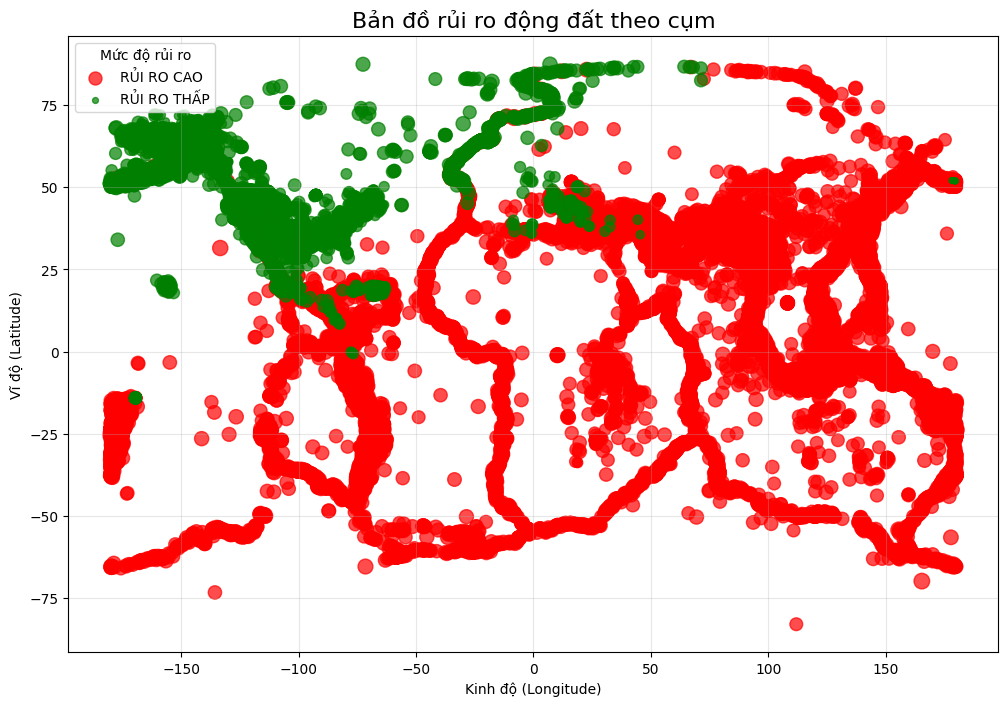

In [0]:
# 9. Vẽ bản đồ rủi ro
risk_colors = {'RỦI RO CAO': 'red', 'RỦI RO TRUNG BÌNH': 'orange', 'RỦI RO THẤP': 'green'}
plt.figure(figsize=(12, 8))
for risk_level, color in risk_colors.items():
    mask = plot_pd['risk_level'] == risk_level
    if mask.any():
        plt.scatter(plot_pd[mask]['longitude'], plot_pd[mask]['latitude'],
                    c=color, label=risk_level, s=plot_pd[mask]['mag']*20, alpha=0.7)
plt.xlabel('Kinh độ (Longitude)')
plt.ylabel('Vĩ độ (Latitude)')
plt.title('Bản đồ rủi ro động đất theo cụm', fontsize=16)
plt.legend(title='Mức độ rủi ro')
plt.grid(True, alpha=0.3)
plt.show()